In [2]:
import keras
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

np.random.seed(1)
ticker = "WFC"

# Open the stock file from the ticker_data dir
TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data"
df = pd.read_csv(f"{TICKER_DIR}\\{ticker}.csv", header=0)

print(df.shape)

# Our target is the close price of the stock
target = df["close"].tail(1000)
dataset = df[["high", "low", "open"]].tail(1000)

Using TensorFlow backend.
(1006, 13)


In [13]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i, _ in enumerate(sequences):
		end_ix = i + n_steps
		if end_ix > len(sequences)-1:
			break
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

n_steps = 3

high = dataset["high"].values.reshape(len(dataset), 1)
low = dataset["low"].values.reshape(len(dataset), 1)
open_ = dataset["open"].values.reshape(len(dataset), 1)
close = target.values.reshape(len(dataset), 1)

# stack them horizontally
d = np.hstack((open_, high, low, close))
# split sequences
sc = MinMaxScaler()
d_sc = sc.fit_transform(d)
X, y = split_sequences(d_sc, n_steps)
# X, y = split_sequences(d, n_steps)

n_features = X.shape[2]
print(d.shape)
print(X.shape)
print(y.shape)

(1000, 4)
(997, 3, 4)
(997, 4)


In [29]:
# clears previous sessions
keras.backend.clear_session()
# es = EarlyStopping(monitor="val_loss", mode="auto", patience=3, verbose=1)
# create a Sequential model, 2 LSTM 100 node layers & 1 fully connected layer
model = Sequential()
model.add(LSTM(100, activation="relu", input_shape=(n_steps, n_features)))#, return_sequences=True))
# model.add(LSTM(100, activation="relu"))
model.add(Dense(n_features))
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="mae", metrics=["mse"])

# split dataset to training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

print(X_train[0], y_train[0])

[[0.3259991  0.33438344 0.32818021 0.35388027]
 [0.36416704 0.3469847  0.28621908 0.28159645]
 [0.29007634 0.3109811  0.29063604 0.32195122]] [0.22317018 0.24977498 0.22570671 0.24124169]


In [30]:
training_history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test))#, callbacks=[es])

In [31]:
# mean_accuracy = np.mean(model.history.history["accuracy"])
mean_loss = np.mean(model.history.history["loss"])
print(f"Mean Loss: {mean_loss}")

Mean Loss: 0.026705276657695155


In [32]:
# evaluate the model with the testing datasets
scores = model.evaluate(X_test, y_test, verbose=0)
print(*[f"History Item [{item}] reports value of {value}" for value, item in zip(scores, model.metrics_names)], sep="\n")
scores

History Item [loss] reports value of 0.01653815507888794
History Item [mse] reports value of 0.0004921916406601667


[0.01653815507888794, 0.0004921916406601667]

In [549]:
with open("scores_lstm.csv", "a") as scores_file:
    scores_file.write(f"{ticker},{mean_loss},{scores[0]},{scores[1]}\n")

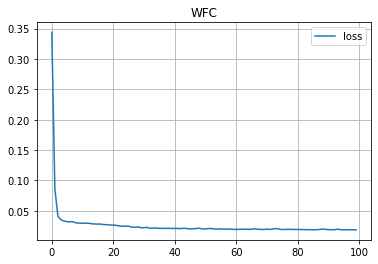

In [550]:
plt.plot(model.history.history["loss"], label="loss")
plt.grid()
plt.legend()
plt.title(ticker)
plt.savefig(f"C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\assets\\losses\\{ticker}.png")

In [551]:
# plt.plot(np.array(model.history.history["accuracy"])*100, label="accuracy", color="red")
# plt.grid()
# plt.legend()
# plt.title(ticker)
# plt.savefig(f"C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\assets\\accuracies\\{ticker}.png")

In [47]:
actual = sc.inverse_transform(y_test)
actual = actual[:, -1]
yhat = model.predict(X_test, verbose=0)
# predictions = yhat[:, -1]
predictions = sc.inverse_transform(yhat)
predictions = predictions[:, -1]

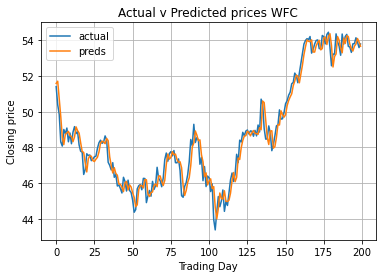

In [48]:
# plot the predicted values against the actual values
fig = plt.figure()
plt.title(f"Actual v Predicted prices {ticker}")
plt.ylabel("Closing price")
plt.xlabel("Trading Day")
plt.plot(actual, label="actual")
plt.plot(predictions, label="preds")
plt.grid()
plt.legend()
# plt.savefig(f"C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\assets\\{ticker}.png")

(20, 4)


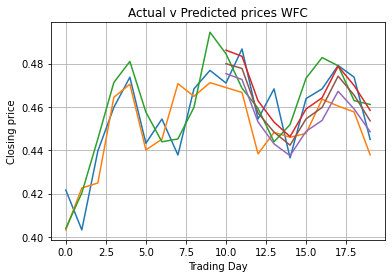

In [35]:
actual = y_test[-20:, :]
X_temp = X_test[-10:]
yhat = model.predict(X_temp, verbose=0)
predictions = np.full(actual.shape, np.NaN)
print(predictions.shape)
predictions[-10:] = yhat[:, :]

fig = plt.figure()
plt.title(f"Actual v Predicted prices {ticker}")
plt.ylabel("Closing price"); plt.xlabel("Trading Day")
plt.plot(actual[:, :3], label="actual")
plt.plot(predictions[:, :3], label="preds")
plt.grid(); #plt.legend()

In [36]:
yhat

array([[0.48621112, 0.47537228, 0.4799596 , 0.48262033],
       [0.48337644, 0.47265208, 0.47775748, 0.48075238],
       [0.46285802, 0.45309085, 0.45720503, 0.46152693],
       [0.45298654, 0.44294754, 0.44836304, 0.4507772 ],
       [0.4463114 , 0.43748805, 0.44234058, 0.44462785],
       [0.45904845, 0.4487635 , 0.45449737, 0.45663056],
       [0.46422857, 0.4537721 , 0.45976195, 0.46208474],
       [0.47882414, 0.4672238 , 0.47420195, 0.47579172],
       [0.46986598, 0.4590622 , 0.46544635, 0.46785513],
       [0.4584195 , 0.44856936, 0.45357582, 0.4566271 ]], dtype=float32)

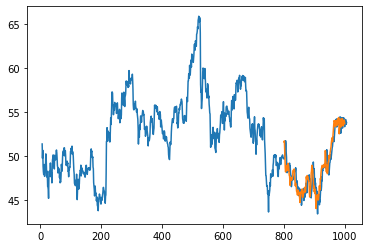

In [50]:
total = np.full_like(target, np.NaN)
total[800:] = predictions

plt.plot(target, label="actual")
plt.plot(total, label="preds")

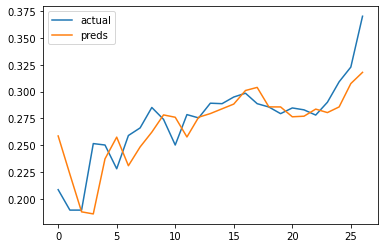

In [73]:
X_2 = X_train[770:801]
p_ = model.predict(X_2, verbose=0)
y_ = y_train[770:801, -1]
plt.plot(y_, label="actual")
plt.plot(p_[:, -1], label="preds")
plt.legend()

# X_2.shape